# Movement prediction with Tensorflow
## I. Read training data

In [1]:
import numpy as np
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Convert PIL image to 200x200 array normalised to -0.5 to 0.5 rage.
def image_2_array(filename):
    # PIL image pil_img
    pil_img=Image.open(filename)
    pil_arr=np.array(pil_img)
    pil_max = np.amax(np.absolute(pil_arr))
    pil_min = np.amin(np.absolute(pil_arr))
    #print ("Max/min:"+ str(pil_max)+"/"+str(pil_min))
    if pil_max == 0:
        # print("Max is 0.")
        return pil_img,pil_arr
    pil_scaled_arr = (pil_arr / pil_max) - 0.5
    return pil_img,pil_scaled_arr

# Invert normalised PIL image
def invert_array(arr):
    #print(arr.shape)
    #print(arr[100][50:60])
    inverted_arr = arr * (-1)
    #print(inverted_arr[100][50:60])
    return inverted_arr
    
# Convert normalized array to PIL image
def array_2_image(arr):
    MAX = 255
    arr_scaled = (arr + 0.5) * MAX
    arr_max = np.amax(arr_scaled)
    arr_min = np.amin(arr_scaled)
    #print ("Array Max/min:"+ str(arr_max)+"/"+str(arr_min))
    im = Image.fromarray(arr_scaled)
    return im

# 0. Image inversion

Only need to run once

In [3]:
# Prepare inversed images
plot = False
save = False  # Only need to save once
if save:
    for dataset in range(1, 11):
        for img_counter in range(1, 11):
            # Read Image
            dataset_str = str(dataset).zfill(3)
            image_str = str(img_counter).zfill(4)
            filename = "/notebooks/data001/move" + \
                    dataset_str+"_"+image_str+".gif"
            #print filename
            img,a = image_2_array(filename)
            #print("Orgarr:")
            #print(a)


            in_arr = invert_array(a)
            #print("Invarr:")
            #print(in_arr)
            new_im = array_2_image(in_arr)
            new_filename = "/notebooks/data001/move_inv_" + \
                    dataset_str+"_"+image_str+".gif"
            # Save new image to file
            new_im.save(new_filename, "GIF")
            # Plot
            if (plot):
                _, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
                ax1.imshow(img);
                ax2.imshow(a, vmin=-0.5, vmax=0.5,cmap=plt.cm.Greys);
                ax3.imshow(in_arr, cmap=plt.cm.Greys);
                ax4.imshow(new_im);



# II. Prepare training set

In [4]:
# Read training images into array of shape (80, 200, 200, 1)
IMSIZE=200
train_data_onedimension = np.array([]) #np.empty([80,200,200,1])
train_labl_onedimension = np.array([])
for dataset in range(1, 9):
    for img_counter in range(1, 11):
        dataset_str = str(dataset).zfill(3)
        image_str = str(img_counter).zfill(4)
        filename = "/notebooks/data001/move" + \
                dataset_str+"_"+image_str+".gif"
        #print filename
        img,a = image_2_array(filename)
        
        train_data_onedimension = np.append(train_data_onedimension,a)
        # Targets
        filename = "/notebooks/data001/move_inv_" + \
                dataset_str+"_"+image_str+".gif"
        #print filename
        img,a = image_2_array(filename)
        train_labl_onedimension = np.append(train_labl_onedimension,a)
        
        
print train_data_onedimension.shape
print train_labl_onedimension.shape

images_in_set = train_data_onedimension.size / (IMSIZE*IMSIZE)
print images_in_set
train_data = train_data_onedimension.reshape(images_in_set, IMSIZE, IMSIZE, 1)

train_labl = train_labl_onedimension.reshape(images_in_set, IMSIZE, IMSIZE, 1)

# Split data between training and test sets 70 : 10
TEST_SIZE = 10
TRAINING_SIZE = images_in_set - TEST_SIZE

test_data  = train_data[:TEST_SIZE,:,:,:]
train_data = train_data[TEST_SIZE:,:,:,:]

test_labl  = train_labl[:TEST_SIZE,:,:,:]
train_labl = train_labl[TEST_SIZE:,:,:,:]
print("Dataset dimentions:")
print train_data.shape
print train_labl.shape
print test_data.shape
print test_labl.shape


(3200000,)
(3200000,)
80
Dataset dimentions:
(70, 200, 200, 1)
(70, 200, 200, 1)
(10, 200, 200, 1)
(10, 200, 200, 1)


## III. Defining model

Code from 3_mnist_from_scratch.
Modified to comply with my data set.

In [5]:
import tensorflow as tf

# We'll bundle groups of examples during training for efficiency.
# This defines the size of the batch.
BATCH_SIZE = 5
# We have only one channel in our grayscale images.
NUM_CHANNELS = 1
# The random seed that defines initialization.
SEED = 12

# This is where training samples and labels are fed to the graph.
# These placeholder nodes will be fed a batch of training data at each
# training step, which we'll write once we define the graph structure.
train_data_node = tf.placeholder(tf.float32,
    shape=(BATCH_SIZE, IMSIZE, IMSIZE, NUM_CHANNELS))

# Changed shape to meet my labels
train_labels_node = tf.placeholder(tf.float32,
    shape=(BATCH_SIZE, IMSIZE, IMSIZE, NUM_CHANNELS))

# For the validation and test data, we'll just hold the entire dataset in
# one constant node.

# Do not use validation
# Checking training results by human (myself)
# validation_data_node = tf.constant(validation_data)
test_data_node = tf.constant(test_data,dtype=tf.float32)

fc1_weights = tf.Variable(  # fully connected, depth 512.
# Outputs random values from a truncated normal distribution.
# https://www.tensorflow.org/versions/r0.11/api_docs/python/constant_op.html#truncated_normal
  tf.truncated_normal([IMSIZE * IMSIZE, IMSIZE * IMSIZE],
                      stddev=0.1,
                      seed=SEED))
fc1_biases = tf.Variable(tf.constant(0.1, shape=[IMSIZE * IMSIZE]))
fc2_weights = tf.Variable(
  tf.truncated_normal([IMSIZE * IMSIZE, IMSIZE * IMSIZE],
                      stddev=0.1,
                      seed=SEED))
fc2_biases = tf.Variable(tf.constant(0.1, shape=[IMSIZE * IMSIZE]))

print 'Done'

Done


## III.a. Define model function 

Combine layers to a NN.

<i>NN types in TF (tf.nn.relu, tf.nn.crelu, tf.nn.softplus, ...): https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html</i>

In [6]:
def model(data):
  """The Model definition."""
  data_shape = data.get_shape().as_list()
  reshape = tf.reshape(data,
      [data_shape[0], data_shape[1] * data_shape[2] * data_shape[3]])
  # Fully connected layer. Note that the '+' operation automatically
  # broadcasts the biases.
  hidden = tf.matmul(reshape, fc1_weights) + fc1_biases
  output = tf.matmul(hidden, fc2_weights) + fc2_biases
  return tf.reshape(output,
        [data_shape[0],data_shape[1],data_shape[2],data_shape[3]])

print 'Done'

Done


## IV. Define loss (cost) function and optimisation algorithm 

*[Tensor Ranks, Shapes, and Types](https://www.tensorflow.org/versions/r0.11/resources/dims_types.html)*



In [8]:
# Predictions for the minibatch, validation set and test set.
train_prediction = model(train_data_node)
print train_labels_node
print train_prediction

loss = tf.reduce_sum(tf.pow(train_labels_node-train_prediction, 2))/(2*BATCH_SIZE)
# tf.reduce_sum(train_labels_node - train_prediction)
# See linear regression sample here: https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/2_BasicModels/linear_regression.py

# L2 regularization for the fully connected parameters.
regularizers = (tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc1_biases) +
                tf.nn.l2_loss(fc2_weights) + tf.nn.l2_loss(fc2_biases))
# Add the regularization term to the loss.
loss += 5e-4 * regularizers
learning_rate = tf.Variable(0.01, name='learning_rate', trainable=False)
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
test_prediction = model(test_data_node)

global_step = tf.Variable(0, name='global_step', trainable=False)
train_op = optimizer.minimize(loss, global_step=global_step)
print loss
print test_prediction


Tensor("Placeholder_1:0", shape=(5, 200, 200, 1), dtype=float32)
Tensor("Reshape_3:0", shape=(5, 200, 200, 1), dtype=float32)
Tensor("add_7:0", shape=(), dtype=float32)
Tensor("Reshape_5:0", shape=(10, 200, 200, 1), dtype=float32)


## V. Do training


In [9]:
# Create a new interactive session that we'll use in
# subsequent code cells.
#config = tf.ConfigProto()
#config.gpu_options.allocator_type = 'BFC'
#s = tf.InteractiveSession(config = config)
s = tf.InteractiveSession()

# Use our newly created session as the default for 
# subsequent operations.
s.as_default()

# Initialize all the variables we defined above.
tf.initialize_all_variables().run()


# Grab the first BATCH_SIZE examples and labels.
batch_data   = train_data[:BATCH_SIZE, :, :, :]
batch_labels = train_labl[:BATCH_SIZE, :, :, :]

# This dictionary maps the batch data (as a numpy array) to the
# node in the graph it should be fed to.
feed_dict = {train_data_node: batch_data,
             train_labels_node: batch_labels}

# Run the graph and fetch some of the nodes.
_, l, lr, predictions = s.run(
  [train_op, loss, learning_rate, train_prediction],
  feed_dict=feed_dict)

print 'Done'
print l


Done
4.80825e+08


<hr>
#### *<span style="color:#e33;font-family:fantasy">Seems to work, but get OOM exeption for BATCH_SIZE=35. Reduced to 5.</span>*

#### *<span style="color:#e33;font-family:fantasy">For tensorflow/tensorflow:0.10.0-gpu even BATCH_SIZE=5 results in OOM.</span>*


<hr>

## VI. Predictions Visualisation

In [10]:
print l
print tf.reduce_sum(train_data[0] - predictions[0])

4.80825e+08
Tensor("Sum_2:0", shape=(), dtype=float64)


<hr>
### *<span style="font-family:fantasy;color:#38e;">Need provide cost (lost) function gradient.</span>*
<hr>
#### *<span style="font-family:fantasy;color:#e83;">Note: Below may hit OOM error.</span>*


In [11]:
train_size = train_data.shape[0]
steps = int(train_size / BATCH_SIZE)
for step in xrange(steps):
  # Compute the offset of the current minibatch in the data.
  # Note that we could use better randomization across epochs.
  offset = (step * BATCH_SIZE) % (train_size - BATCH_SIZE)
  print('Step %d of %d. Data %d - %d ' % (step, steps, offset,offset + BATCH_SIZE))
  batch_data   = train_data[offset:(offset + BATCH_SIZE), :, :, :]
  batch_labels = train_labl[offset:(offset + BATCH_SIZE), :, :, :]
  # This dictionary maps the batch data (as a numpy array) to the
  # node in the graph it should be fed to.
  feed_dict = {train_data_node: batch_data,
               train_labels_node: batch_labels}
  # Run the graph and fetch some of the nodes.
  _, l, lr, predictions = s.run(
    [train_op, loss, learning_rate, train_prediction],
    feed_dict=feed_dict)

  
  # Print out the loss
  print 'Mini-batch loss: %.5f ' % (l)


Step 0 of 14. Data 0 - 5 
Mini-batch loss: 14615376082187160668602368.00000 
Step 1 of 14. Data 5 - 10 
Mini-batch loss: inf 
Step 2 of 14. Data 10 - 15 
Mini-batch loss: nan 
Step 3 of 14. Data 15 - 20 
Mini-batch loss: nan 
Step 4 of 14. Data 20 - 25 
Mini-batch loss: nan 
Step 5 of 14. Data 25 - 30 
Mini-batch loss: nan 
Step 6 of 14. Data 30 - 35 
Mini-batch loss: nan 
Step 7 of 14. Data 35 - 40 
Mini-batch loss: nan 
Step 8 of 14. Data 40 - 45 
Mini-batch loss: nan 
Step 9 of 14. Data 45 - 50 
Mini-batch loss: nan 
Step 10 of 14. Data 50 - 55 
Mini-batch loss: nan 
Step 11 of 14. Data 55 - 60 
Mini-batch loss: nan 
Step 12 of 14. Data 60 - 65 
Mini-batch loss: nan 
Step 13 of 14. Data 0 - 5 
Mini-batch loss: nan 


## Test cross-entropy function

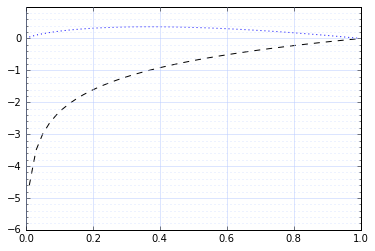

In [43]:
from matplotlib.ticker import AutoMinorLocator

# evenly sampled at 0.2 intervals
y = np.arange(0.01, 1., 0.02)
z = np.log(y)
#zn= - np.log(1-y)
#zl= (z + zn)

# Cross-entropy
H = -y*z
#Hr = -y*np.log(y+0.2)
plt.plot(y, z, 'k--', y, H, 'b:')
axes = plt.gca()
axes.set_xlim([0,1])
axes.set_ylim([-6,1])
major_ticks = np.arange(-6, 1, 1)
ml = AutoMinorLocator(5)
minor_ticks = np.arange(-6, 1, 0.2)
plt.yticks(major_ticks)
plt.axes().yaxis.set_minor_locator(ml)
#plt.yticks(minor_ticks)
plt.grid(b=True, which='major', color='#bbccff', linestyle='-')
plt.grid(b=True, which='minor', color='#bbccff', linestyle=':')
plt.show()

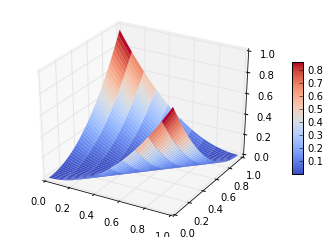

In [76]:
# 3D plot of cost function
# y - real data
# h - hypthesis

from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax = fig.gca(projection='3d')
y = np.arange(0.01, 1., 0.02)
h = np.arange(0.01, 1., 0.02)
y, h = np.meshgrid(y, h)
z = -y*np.log(h)
z1= (y - h)**2
#ax.plot_wireframe(y, h, z, rstride=10, cstride=10)
surf = ax.plot_surface(y, h, z1, rstride=1, cstride=5, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)

fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()

## DNN manual definition experiments

Not sure if they are useful.

In [70]:
import tensorflow as tf

# Set max value to be 1
def normalise(y):
    max_v = np.amax(y)
    return y/max_v
    

$$y = Wx + b$$

In [83]:
# Length of one image in elements
image_len = IMSIZE*IMSIZE
x = tf.placeholder(tf.float32, [None, image_len])
W = tf.Variable(tf.zeros([image_len, image_len]))
b = tf.Variable(tf.zeros([image_len]))
y = tf.matmul(x, W) + b
# Add print operation
y = tf.Print(y, [y], message="y= ")
y_ = tf.placeholder(tf.float32, [None, image_len])

# Cost function

In [99]:
J = -tf.reduce_sum((y_ - y)*(y_ - y),reduction_indices=[1])

In [103]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(J)
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
BATCHSIZE=1


In [104]:
def get_next_batch(data,i,BATCHSIZE,IMSIZE):
    image_len = IMSIZE*IMSIZE
    batch_len = BATCHSIZE*image_len
    start_index = i*batch_len
    end_index = i*batch_len + batch_len
    return data[start_index:end_index].reshape(BATCHSIZE,image_len)

In [105]:
with sess.as_default():   # or `with sess:` to close on exit
    assert sess is tf.get_default_session()
    batchX = get_next_batch(train_data_onedimension,0,BATCHSIZE,IMSIZE)
    print(batchX)
    print(batchX.shape)
    batchY = get_next_batch(train_labl_onedimension,0,BATCHSIZE,IMSIZE)
    print(batchY)
    print(batchY.shape)
    sess.run(train_step, feed_dict={x: batchX, y_: batchY})
    y.eval()

[[-0.5 -0.5 -0.5 ...,  0.5  0.5  0.5]]
(1, 40000)
[[ 0.5  0.5  0.5 ..., -0.5 -0.5 -0.5]]
(1, 40000)


InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_14' with dtype float
	 [[Node: Placeholder_14 = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]
Caused by op u'Placeholder_14', defined at:
  File "/usr/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-83-0d97e1ef839d>", line 3, in <module>
    x = tf.placeholder(tf.float32, [None, image_len])
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/array_ops.py", line 762, in placeholder
    name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 976, in _placeholder
    name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/op_def_library.py", line 655, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2154, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1154, in __init__
    self._traceback = _extract_stack()


In [ ]:
for i in range(int(images_in_set/BATCHSIZE)):
    print(i)
    batchX = get_next_batch(train_data_onedimension,i,BATCHSIZE,IMSIZE)
    batchY = get_next_batch(train_labl_onedimension,i,BATCHSIZE,IMSIZE)
    sess.run(train_step, feed_dict={x: batchX, y_: batchY})
    y.eval()

In [82]:
sess.run(y.eval())

ValueError: Cannot evaluate tensor using eval(): No default session is registered. Use `with sess.as_default()` or pass an explicit session to eval(session=sess)

Training dataset is ready. 

*Note!* dataset should be trained with N images on input and 1 image on output. (test with N = 3..5)

Training data shape (80, 200, 200, 1)


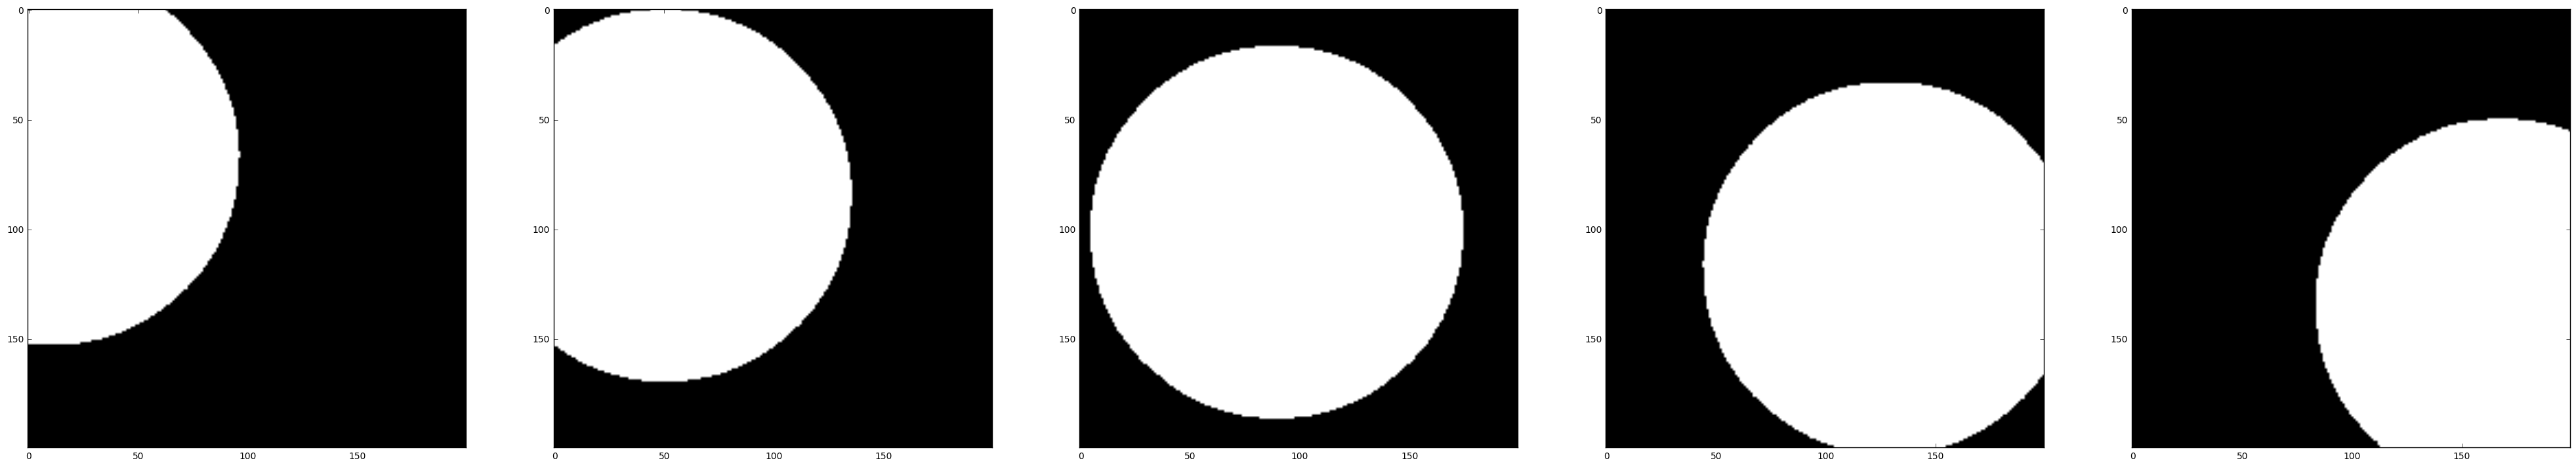

In [5]:
print 'Training data shape', train_data.shape
_, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(50,50))
ax1.imshow(train_data[2].reshape(img_width, img_width), cmap=plt.cm.Greys);
ax2.imshow(train_data[3].reshape(img_width, img_width), cmap=plt.cm.Greys);
ax3.imshow(train_data[4].reshape(img_width, img_width), cmap=plt.cm.Greys);
ax4.imshow(train_data[5].reshape(img_width, img_width), cmap=plt.cm.Greys);
ax5.imshow(train_data[6].reshape(img_width, img_width), cmap=plt.cm.Greys);